# Setup

In [1]:
!wget https://data.bts.gov/api/views/crem-w557/rows.csv

--2023-07-04 13:40:57--  https://data.bts.gov/api/views/crem-w557/rows.csv
Resolving data.bts.gov (data.bts.gov)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.bts.gov (data.bts.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv’

rows.csv                [ <=>                ] 482.57K  --.-KB/s    in 0.1s    

2023-07-04 13:40:57 (4.27 MB/s) - ‘rows.csv’ saved [494151]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('rows.csv')
#need to sort it for most recent data, since the data starts after 1947
#just need years 2018 and after
#make filter where date >= a certain timestamp

#remove the timestamp from the date
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Date'] = pd.to_datetime(df['Date'])
start_date = "2018-12-31"
mask = (df['Date'] > start_date)
df = df.loc[mask]
df.head()

p_vals = []
p_labels = []

np.random.seed(42)

# EDA

## Spending on mass trainsit EDA

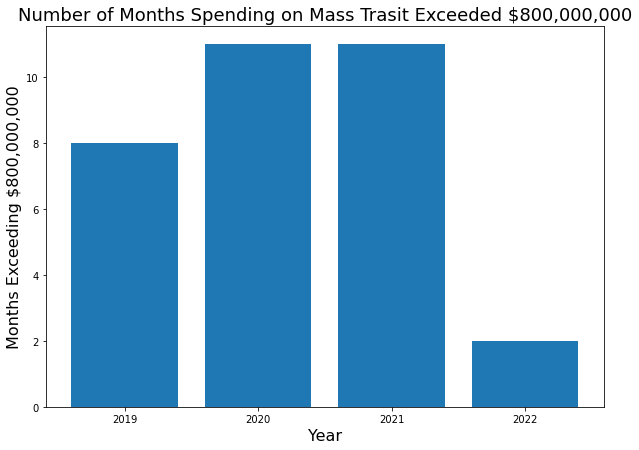

In [ ]:
#Creates a dataframe with the date and spending on mass transit
data_vis = df[['Date', 'State and Local Government Construction Spending - Mass Transit']]

#Creates an indicator if more that $800,000,000 was spent on mass transit
data_vis['State and Local Government Construction Spending - Mass Transit'] =\
 data_vis['State and Local Government Construction Spending - Mass Transit'].apply(lambda x: 1 if x >= 800000000 else 0)

#Converts the dates to years
data_vis['Date'] = pd.DatetimeIndex(data_vis['Date']).year

#Groups the indicators by year and finds the count of the indicators
data_vis = data_vis.groupby(by=["Date"]).sum()
#Displays the number of months out of each year where more that $800,000,000 was spent on mass transit
plt.figure(figsize = (10, 7))
plt.bar(data_vis.index.astype(str), data_vis["State and Local Government Construction Spending - Mass Transit"])
plt.title("Number of Months Spending on Mass Trasit Exceeded $800,000,000", fontsize=18)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Months Exceeding $800,000,000", fontsize=16);

## Differences in spending EDA

In [ ]:
#Finds all of the columns that have construction spending
spending = df.columns
spending.to_list()
spending_string = "State and Local Government Construction Spending"
spending = [col for col in spending if spending_string in col]

In [ ]:
#Creates a dataframe with the spending and the dates
spending_df = df[spending + ['Date']]

#Creates two dataframes with the spending from 2019 and 2020 respectively
spending_2019 = spending_df[(spending_df['Date'] > "2018-12-01") & (spending_df['Date'] < "2020-01-01")].drop('Date', axis = 1)
spending_2020 = spending_df[(spending_df['Date'] > "2019-12-01") & (spending_df['Date'] < "2021-01-01")].drop('Date', axis = 1)

#Finds the average spending in each category
average_spending_2019 = spending_2019.sum(axis = 0) / 12
average_spending_2020 = spending_2020.sum(axis = 0) / 12

#Finds the percent differences between the average spending between 2020 and 2019
average_differences = abs(average_spending_2020 - average_spending_2019) / ((average_spending_2020 + average_spending_2019) / 2) *  100
sorted_average_differences = average_differences.sort_values(ascending=False)
sorted_average_differences.head(10)

State and Local Government Construction Spending - Land Passenger Terminal    54.121759
State and Local Government Construction Spending - Pump Station               39.520060
State and Local Government Construction Spending - Special Care               35.244161
State and Local Government Construction Spending - Sewage Treatment Plant     32.662983
State and Local Government Construction Spending - Rest Facility              31.092437
State and Local Government Construction Spending - Residential                28.730745
State and Local Government Construction Spending - Multi Family               25.971773
State and Local Government Construction Spending - Bridge                     20.972371
State and Local Government Construction Spending - Automotive                 19.452888
State and Local Government Construction Spending - Dormitory                  18.635281
dtype: float64

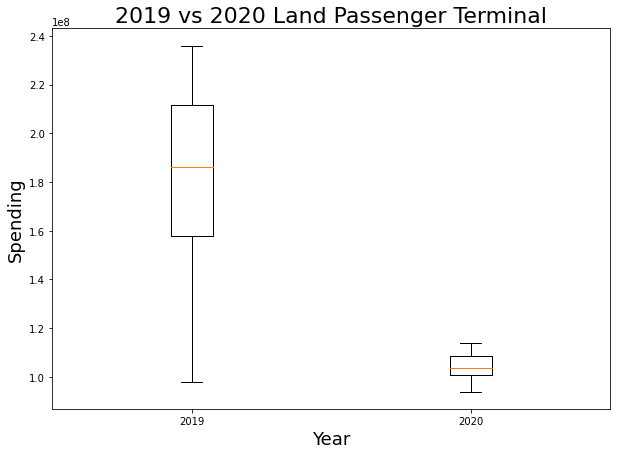

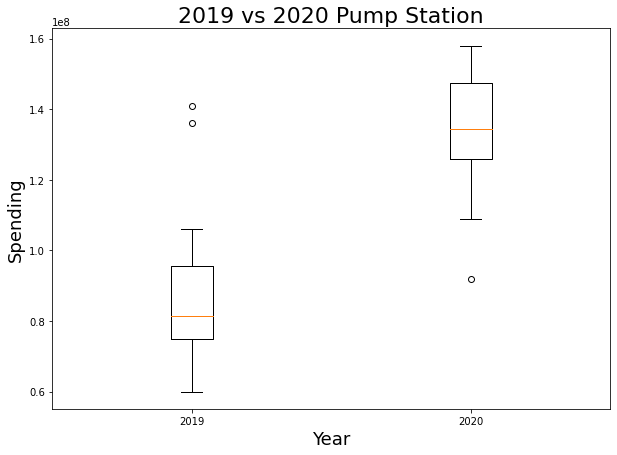

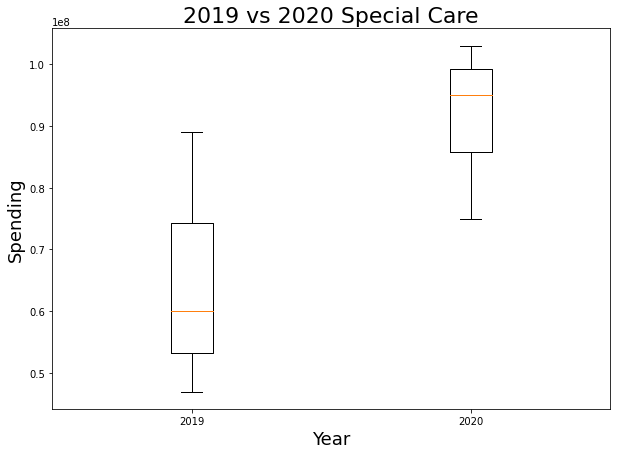

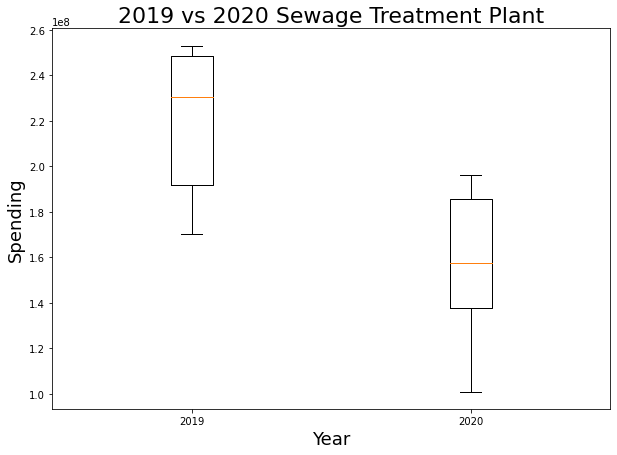

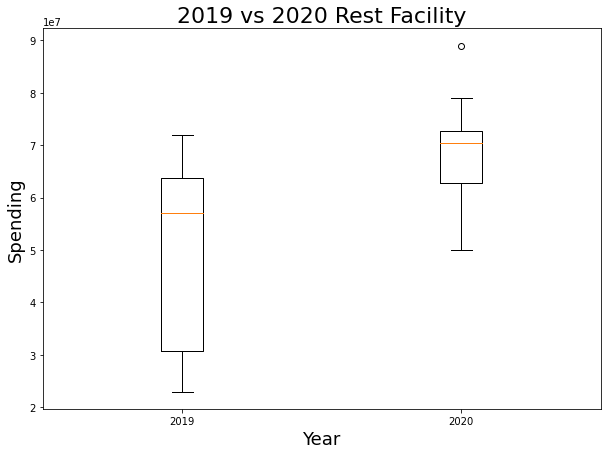

In [ ]:
#Finds and displays the top 5 percent differences between average spending in 2020 and 2019
top_5_diffs = sorted_average_differences.index[:5].to_list()
def show_boxplot(series1, series2, col, labels = ['2019', '2020']):
    plt.figure(figsize = (10, 7))
    plt.title('2019 vs 2020 {}'.format(col[51:]), fontsize = 22)
    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('Spending', fontsize = 18)
    plt.boxplot([series1[col], series2[col]], labels=labels)
    plt.show()

for col in top_5_diffs:
    show_boxplot(spending_2019, spending_2020, col)

## Data Cleaning for 2nd Research question

In [ ]:
#Turn the transportation data into a dataframe
df = pd.read_csv('rows.csv')
#Get year and turn date in to a datetime object
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Date'] = pd.to_datetime(df['Date'])

spending = df.columns
spending.to_list()
spending_string = "State and Local Government Construction Spending"
spending = [col for col in spending if spending_string in col]

#Create a dataframe with the proportions of the total
spending_props = df[spending]
spending_props = spending_props.divide(spending_props["State and Local Government Construction Spending - Total"], axis=0)
spending_props = spending_props.drop("State and Local Government Construction Spending - Total", axis=1)
spending_props['Year'] = df['Year']
spending_props['Date'] = df['Date']

#Treatment and effect variables
spending_props['Riders'] = df['Transit Ridership - Urban Rail - Adjusted']
spending_props['Employees'] = df['Transportation Employment - Rail Transportation']

#Possible Confounders
"""spending_props["Other Ridership"] = df['Transit Ridership - Other Transit Modes - Adjusted']
spending_props["Fixed Route Bus Ridership"] = df["Transit Ridership - Fixed Route Bus - Adjusted"]
spending_props['Passenger Miles'] = df["Passenger Rail Passenger Miles"]
spending_props["Train Miles"] = df["Passenger Rail Total Train Miles"]
spending_props['Gas Price'] = df["Highway Fuel Price - Regular Gasoline"]
spending_props['Diesel Price'] = df["Highway Fuel Price - On-highway Diesel"]"""
spending_props = spending_props.dropna()

## Research Question 2 - Visualization #1: Quantitative

In [ ]:
riders = 'Transit Ridership - Urban Rail - Adjusted'
employees = 'Transportation Employment - Rail Transportation'

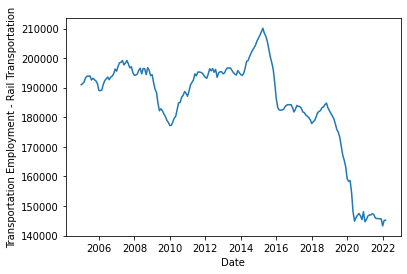

In [ ]:
sns.lineplot(data=df, x='Date', y=employees);

## Research Question 2 - Visualization #2: Categorical

In [ ]:
# do ridership and employment both decrease/increase in the same pattern each year?

grouped_df = df.groupby("Year").mean()
grouped_df = grouped_df[grouped_df[employees] > 0]
grouped_df = grouped_df[[riders, employees]]

riders_incr = []
employees_incr = []

for i in list(grouped_df.index):
  if i == 2005:
    riders_incr.append(False)
  else:
    if (grouped_df[riders][i] > grouped_df[riders][i - 1]):
      riders_incr.append(True)
    else:
      riders_incr.append(False)

for i in list(grouped_df.index):
  if i == 2005:
    employees_incr.append(False)
  else:
    if (grouped_df[employees][i] > grouped_df[employees][i - 1]):
      employees_incr.append(True)
    else:
      employees_incr.append(False)

grouped_df["Ridership increased from year before?"] = riders_incr
grouped_df["Employment increased from year before?"] = employees_incr

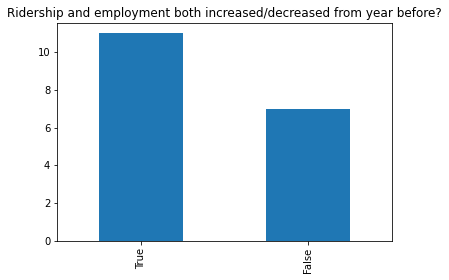

In [ ]:
grouped_df["ridership and employment both increased/decreased from year before?"] = np.where(((grouped_df["Ridership increased from year before?"] == True) & (grouped_df["Employment increased from year before?"] == True) | (grouped_df["Ridership increased from year before?"] == False) & (grouped_df["Employment increased from year before?"] == False)), True, False)

plt = grouped_df["ridership and employment both increased/decreased from year before?"].value_counts().plot.bar(title = "Ridership and employment both increased/decreased from year before?")
plt;

# Hypothesis Testing

In [ ]:
df = pd.read_csv('rows.csv') # load back in initial dataset
#need to sort it for most recent data, since the data starts after 1947
#just need years 2018 and after
#make filter where date >= a certain timestamp

#remove the timestamp from the date
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Date'] = pd.to_datetime(df['Date'])
start_date = "2018-12-31"
mask = (df['Date'] > start_date)
df = df.loc[mask]
df.head()

p_vals = []
p_labels = []

np.random.seed(42)

In [ ]:
def abs_diff_means(df, group):
  ''' assumes df has just 2 cols label_col, test_col'''
  means = df.groupby(group).mean()
  return float(abs(means.iloc[0] - means.iloc[1]))

def ab_test(df, label_col, test_col, test_statistic=abs_diff_means):
  df = df.copy()
  df['shuffled_labels'] = np.array(df[label_col].sample(frac=1, replace=False))
  return test_statistic(df[['shuffled_labels', test_col]], 'shuffled_labels')

def run_simulations(num_sims, df, label_col, test_col, test_statistic=abs_diff_means):
  sample_stats = np.array([])
  observed_stat = test_statistic(df, label_col)
  for i in range(num_sims):
    sample_stat = ab_test(df, label_col, test_col, test_statistic)
    sample_stats = np.append(sample_stats, sample_stat)

  return np.count_nonzero(sample_stats >= observed_stat) / num_sims

def naive_test(p_vals, alpha=0.05):
  #True if discovery otherwise False
  return p_vals <= alpha, alpha

def bonferroni_correction(p_vals, alpha=0.05):
  #True if discovery otherwise False
  #Controls groupwise error rate
  return p_vals <= alpha/len(p_vals), alpha/len(p_vals)

def benjamini_correction(p_vals, alpha=0.05):
  #True if discovery otherwise False
  #Controls False Discovery Rate (FDR)
  ordered_p_vals = np.sort(p_vals)
  cutoffs = ordered_p_vals <= alpha/len(p_vals) * np.arange(1, len(p_vals) + 1)
  k = np.max(np.arange(len(p_vals))[cutoffs])
  return p_vals <= ordered_p_vals[k], ordered_p_vals[k]

Hypothesis 1: There were more miles by land traveled during 2020 than 2019.

Null Hypothesis 1: There was no change in miles by land traveled in both 2020 and    2019.


In [ ]:
miles_df = df[['Year', 'Highway Vehicle Miles Traveled - All Systems']]

end_date = 2021
mask = (miles_df['Year'] < end_date)
miles_df = miles_df.loc[mask]

miles_p_val = run_simulations(10000, miles_df, 'Year', 'Highway Vehicle Miles Traveled - All Systems', abs_diff_means)
p_vals.append(miles_p_val)
p_labels.append('Miles Traveled')
miles_p_val

0.0024

Hypothesis 2: There was more spending on transportation by land in 2020 than 2019.

Null Hypothesis 2: There was no more spending on transportation by land in both 2020 and 2019.


In [ ]:
spending_df = df[['Year', 'State and Local Government Construction Spending - Transportation']]
end_date = 2021
mask = (spending_df['Year'] < end_date)
spending_df = spending_df.loc[mask]

transportation_p_val = run_simulations(10000, spending_df, 'Year', 'State and Local Government Construction Spending - Transportation')
p_vals.append(transportation_p_val)
p_labels.append('Transportation Spending')
transportation_p_val

0.1276

Hypothesis 3: There was more spending on transportation mass transit in 2020 than 2019.

Null Hypothesis 3: There was no difference in the spending on mass transit in 2020 and 2019.


In [ ]:
spending_mass_transit_df = df[['Year', 'State and Local Government Construction Spending - Mass Transit']]
end_date = 2021
mask = (spending_mass_transit_df['Year'] < end_date)
spending_mass_transit_df = spending_mass_transit_df.loc[mask]

mass_transit_p_val = run_simulations(10000, spending_mass_transit_df, 'Year', 'State and Local Government Construction Spending - Mass Transit')
p_vals.append(transportation_p_val)
p_labels.append('Mass Transit Spending')
mass_transit_p_val

0.076



Hypothesis 4: There was more spending on highways and streets in 2020 than 2019.

Null Hypothesis 4: There was no difference in the spending on highways and streets in 2020 and 2019.


In [ ]:
spending_highway_and_street_df = df[['Year',  'State and Local Government Construction Spending - Highway and Street']]
end_date = 2021
mask = (spending_highway_and_street_df['Year'] < end_date)
spending_highway_and_street_df = spending_highway_and_street_df.loc[mask]

highway_and_street_p_val = run_simulations(10000, spending_highway_and_street_df, 'Year', 'State and Local Government Construction Spending - Highway and Street')
p_vals.append(highway_and_street_p_val)
p_labels.append('Highway and Street Spending')
highway_and_street_p_val

0.949

Hypothesis 5: There was more spending on infrastructure in 2020 than 2019.

Null Hypothesis 5: There was no difference in the spending on infrastructure in 2020 and 2019.


In [ ]:
spending_infrastructure_df = df[['Year',  'State and Local Government Construction Spending - Infrastructure']]
end_date = 2021
mask = (spending_infrastructure_df['Year'] < end_date)
spending_infrastructure_df = spending_infrastructure_df.loc[mask]

infrastructure_p_val = run_simulations(10000, spending_infrastructure_df, 'Year', 'State and Local Government Construction Spending - Infrastructure')
p_vals.append(infrastructure_p_val)
p_labels.append('Infrastructure Spending')
infrastructure_p_val

0.0533

Hypothesis 6: There was more spending on pavement in 2020 than 2019.

Null Hypothesis 6: There was no difference in the spending on pavement in 2020 and 2019.


In [ ]:
spending_pavement_df = df[['Year',  'State and Local Government Construction Spending - Pavement']]
end_date = 2021
mask = (spending_pavement_df['Year'] < end_date)
spending_pavement_df = spending_pavement_df.loc[mask]

pavement_p_val = run_simulations(10000, spending_pavement_df, 'Year', 'State and Local Government Construction Spending - Pavement')
p_vals.append(pavement_p_val)
p_labels.append('Pavement Spending')
pavement_p_val

0.6112

## Error Correction

In [ ]:
#Find discoveries and cutoffs
p_vals = np.array(p_vals)
p_labels = np.array(p_labels)
alpha = 0.05
naive_discoveries, naive_cutoff = naive_test(p_vals, alpha)
bonferroni_discoveries, bonferroni_cutoff = bonferroni_correction(p_vals, alpha)
bh_discoveries, bh_cutoff = benjamini_correction(p_vals, alpha)

#Print P-Values
print("----------------------------- P-Values -----------------------------")
for label, p_val in zip(p_labels, p_vals):
  print(label, " P-Value = {:.5f}".format(p_val))

#Print what test reject the null hypothesis for each respective cutoff
print("\n\n----------------------------- Discoveries -----------------------------")
print("Naive Cutoff of {:.5f} rejects the null for:".format(naive_cutoff))
for label in p_labels[naive_discoveries]:
  print(label)
if sum(naive_discoveries) == 0:
  print("None of the hypothesis tests")
print("\n")

print("Bonferroni Cutoff of {:.5f} rejects the null for:".format(bonferroni_cutoff))
for label in p_labels[bonferroni_discoveries]:
  print(label)
if sum(bonferroni_discoveries) == 0:
  print("None of the hypothesis tests")
print("\n")

print("Benjamini-Hochberg Cutoff of {:.5f} rejects the null for:".format(bh_cutoff))
for label in p_labels[bh_discoveries]:
  print(label)
if sum(bh_discoveries) == 0:
  print("None of the hypothesis tests")
print("\n")

----------------------------- P-Values -----------------------------
Miles Traveled  P-Value = 0.00240
Transportation Spending  P-Value = 0.12760
Mass Transit Spending  P-Value = 0.12760
Highway and Street Spending  P-Value = 0.94900
Infrastructure Spending  P-Value = 0.05330
Pavement Spending  P-Value = 0.61120


----------------------------- Discoveries -----------------------------
Naive Cutoff of 0.05000 rejects the null for:
Miles Traveled


Bonferroni Cutoff of 0.00833 rejects the null for:
Miles Traveled


Benjamini-Hochberg Cutoff of 0.00240 rejects the null for:
Miles Traveled




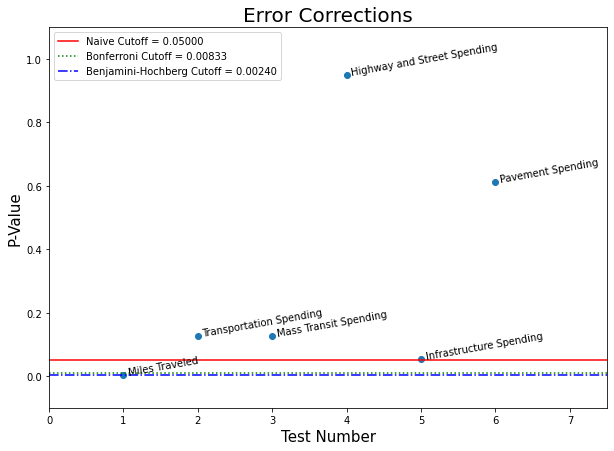

In [ ]:
#Display the p-value data points and the cutoffs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Error Corrections", fontsize=20)
plt.xlabel("Test Number", fontsize=15)
plt.ylabel("P-Value", fontsize=15)
plt.scatter(np.arange(1, len(p_vals) + 1), p_vals)
for test_name, xy in zip(p_labels, zip(np.arange(1, len(p_vals) + 1) + 0.05, p_vals)):
  plt.annotate(test_name, xy, rotation=10)
plt.xlim(0, len(p_vals) + 1.5)
plt.ylim(-0.1, 1.1)
plt.axhline(y=naive_cutoff, color='red', label='Naive Cutoff = {:.5f}'.format(naive_cutoff))
plt.axhline(y=bonferroni_cutoff, color='green', linestyle=':', label='Bonferroni Cutoff = {:.5f}'.format(bonferroni_cutoff))
plt.axhline(y=bh_cutoff, color='blue' , linestyle='-.', label='Benjamini-Hochberg Cutoff = {:.5f}'.format(bh_cutoff))
plt.legend(loc='upper left');

# Causal Inference

In [ ]:
df = pd.read_csv('rows.csv') # load back in initial dataset

#Find the columns in the dataset that contain State and Local Government Spending
spending = df.columns
spending.to_list()
spending_string = "State and Local Government Construction Spending"
spending = [col for col in spending if spending_string in col]

#Create a dataframe with the proportions of the total spending for each month
spending_props = df[spending]
spending_props = spending_props.divide(spending_props["State and Local Government Construction Spending - Total"], axis=0)
spending_props = spending_props.drop("State and Local Government Construction Spending - Total", axis=1)

#Add back in the treatment and effect variables
spending_props['Riders'] = df['Transit Ridership - Urban Rail - Adjusted']
spending_props['Employees'] = df['Transportation Employment - Rail Transportation']
spending_props = spending_props.dropna()

In [ ]:
#Create treatment indicator using urban rail ridership
#Effect is the number of employees in a given month
#Treatment is if the number of urben rail riders from last month is greater than the average riders from the previous months_out months excluding last month
#Counfounders are spending from months_out ago from last month

#EXAMPLE
#Effect = The number of employees in August
#Treatment = if the number of riders in July > the average number of riders from June to january
#Confounders = Spending from January

#Method to find the average
def get_averages(series, months_out=6):
  totals = series[:-months_out-1].reset_index(drop=True)
  for i in range(1, months_out - 1):
    totals = totals + series[i:-months_out + i - 1].reset_index(drop=True)
  totals = totals / (months_out - 1)
  return totals



months_out = 7

six_month_averages = get_averages(spending_props['Riders'], months_out).reset_index(drop=True)
treatment =  spending_props['Riders'].iloc[:-months_out-1].reset_index(drop=True) > six_month_averages
treatment_df = spending_props.iloc[:-months_out - 1].reset_index(drop=True)
treatment_df['Employees'] = spending_props["Employees"][months_out+1:].reset_index(drop=True)
treatment_df["Increased Ridership"] = treatment
treatment_df = treatment_df.drop("Riders", axis=1)

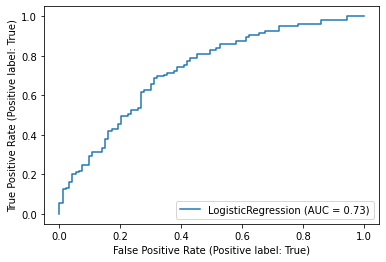

In [ ]:
#Confounders list
confounders = ["State and Local Government Construction Spending - Mass Transit",
"State and Local Government Construction Spending - Highway and Street",
"State and Local Government Construction Spending - Transportation",]

#Creates the propensity model with the confounders as input and treatment as output
propensity_model = LogisticRegression()
X = treatment_df[confounders]
Y = treatment_df["Increased Ridership"]
trained_model = propensity_model.fit(X, Y)

#Creates an ROC curve to check the validity of the propensity model
propensity_scores = trained_model.predict_proba(X)[:, 0]
plot_roc_curve(trained_model, X, Y)
plt.show()

In [ ]:
#Creates arrays of the effects and propensity scores
treatment_group = treatment_df[Y]['Employees'].to_numpy()
control_group = treatment_df[Y == False]['Employees'].to_numpy()
treatment_props = propensity_scores[Y]
control_props = 1 - propensity_scores[Y == False]

#Calculates the Niave and Inverse Propensity Weighting Average Treatment Effects
naive_ATE = treatment_group.mean() - control_group.mean()
ipw_ATE = (treatment_group / treatment_props).mean() - (control_group / control_props).mean()

#Print the results
print("Naive Average Treatment Effect = {}".format(naive_ATE))
print("Inverse Propensity Weighting Average Treatment Effect = {}".format(ipw_ATE))

Naive Average Treatment Effect = 2961.136712749634
Inverse Propensity Weighting Average Treatment Effect = 51931.53646671376
